In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER


## Requirements

In [3]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


     |████████████████████████████████| 3.8 MB 34.4 MB/s 
     |████████████████████████████████| 895 kB 61.8 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
     |████████████████████████████████| 6.5 MB 56.4 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch

In [6]:
MODEL_PATH = 'bert-base-cased'

In [7]:
tokenizer_name = 'bert-base-cased'

In [8]:
num_train_epochs = 5 
if 'dist' in MODEL_PATH:
  num_train_epochs = 3 # distil BERT usually needs less epoch than full bert

In [9]:
print(MODEL_PATH)

bert-base-cased


In [10]:
num_train_epochs

5

## Dataset Preprocessing


Dataset config file

In [11]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/"

root_data_dir = os.path.join(root_dir, "datasets", "QEMP")

dataset = "train"
train_csv_file_path = "train.csv"
test_csv_file_path = "test.csv"

Data loading utils

In [12]:
def loadData(csv_file_path):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="utf8", sep=',')
  data = data.fillna(method="ffill")
  return data

In [13]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),                                                          
                                                        s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [14]:
data = loadData(train_csv_file_path)

In [15]:
data.head(5)

,Sentence #,Word,Tag
0,Sentence: 1,C,O
1,Sentence: 1,carbon,O
2,Sentence: 1,C/N,O
3,Sentence: 1,ratio,B-Quality
4,Sentence: 1,CSP,O


In [16]:
test_data =  loadData(test_csv_file_path)

In [17]:
test_data.head(5)

,Sentence #,Word,Tag
0,Sentence: 1,The,O
1,Sentence: 1,commercial,O
2,Sentence: 1,use,O
3,Sentence: 1,of,O
4,Sentence: 1,any,O


Preparation of VOCAB and tags lists

In [18]:
#if the data are in string style, we propably use tokenzer.fit_on_texts instead of list manipulation like here

VOCAB = list(set(list(data["Word"].values) +                  
                 list(test_data["Word"].values)))
VOCAB.append("ENDPAD")

n_words = len(VOCAB) #n_words includes all vocab from train and validation test.

tags = list(set(data["Tag"].values))

n_tags = len(tags)


In [19]:
print(n_words, VOCAB[0:10] ,VOCAB[n_words-1], sep='\n')

7520
['param169339', 'grass', 'removing', 'abiotic', 'ten', 'bottom', 'habitats', 'review', 'BM_below', 'param77404']
ENDPAD


In [20]:
print(n_tags, tags, sep='\n')

9
['I-Material', 'B-Quality', 'I-Process', 'I-Environment', 'O', 'B-Process', 'I-Quality', 'B-Environment', 'B-Material']


### Data Explortion

Creating sentences for train, val and test sets.

In [21]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [22]:
getter_test = SentenceGetter(test_data)
sentences_test = getter_test.sentences

In [23]:
sent = getter_test.get_next()
print(sent)

[('The', 'O'), ('commercial', 'O'), ('use', 'O'), ('of', 'O'), ('any', 'O'), ('data', 'O'), ('is', 'O'), ('prohibited', 'O'), ('.', 'O')]


Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. after running the below cells, we will find that COPIOUS has longer sentences than BERT which means it will trim them.

In [24]:
plt.style.use("ggplot")

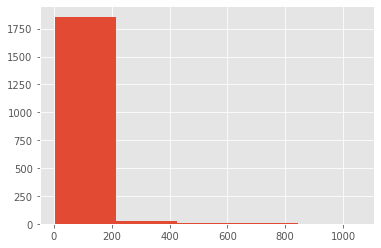

In [25]:
plt.hist([len(s) for s in sentences], bins=5)
plt.show()

In [26]:
max([len(s) for s in sentences]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

1056

### Encoder Format

Encoder/Decoder dictonaries for tags

In [27]:
tag2id = {tag: id for id, tag in enumerate(tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

Split texts from tags (use two different python lists)

In [28]:
def get_text_tags_lists(sentences):
  texts = []
  tags = []
  for sent in sentences: #list of tuples    
    sent_texts = []
    sent_tags = []  
    for tuple1 in sent:  
      sent_texts.append(tuple1[0])
      sent_tags.append(tuple1[1])

    texts.append(sent_texts)
    tags.append(sent_tags)
  return texts, tags

In [29]:
train_texts, train_tags = get_text_tags_lists(sentences)
test_texts, test_tags = get_text_tags_lists(sentences_test)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train_texts, val_texts, train_tags, val_tags = train_test_split(train_texts, train_tags, test_size=0.2)

In [32]:
max([len(s) for s in train_texts])

1056

## BERT

In [33]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast
print(tokenizer_name)
if 'dist' in tokenizer_name:
  tokenizer = DistilBertTokenizerFast.from_pretrained(tokenizer_name)
else:
  tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
test_encodings = tokenizer(test_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

bert-base-cased


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Label Mismatch Solution

In [34]:
def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):      
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        #since we enabled the truncation=ture in the encoding, we should handle this again in the labels
        max_len = len(doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)]) 

        # set labels whose first offset position is 0 and the second is not 0 
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels[0:max_len]

    
        encoded_labels.append(doc_enc_labels.tolist())
    return encoded_labels

In [35]:
train_labels = encode_tags(train_tags, train_encodings)

In [36]:
val_labels = encode_tags(val_tags, val_encodings)

In [37]:
test_labels = encode_tags(test_tags, test_encodings)

### Inspect

In [38]:
tag2id

{'B-Environment': 7,
 'B-Material': 8,
 'B-Process': 5,
 'B-Quality': 1,
 'I-Environment': 3,
 'I-Material': 0,
 'I-Process': 2,
 'I-Quality': 6,
 'O': 4}

In [39]:
len(train_encodings['input_ids'])

1521

In [40]:
for i in train_encodings['input_ids'][0:3]:
  print(len(i), i)

512 [101, 16409, 26671, 131, 169, 169, 185, 10973, 1571, 25129, 1568, 112, 112, 131, 169, 169, 185, 112, 112, 2086, 1115, 1142, 1110, 170, 4928, 1115, 1110, 9467, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
for i in train_labels[0:3]: # each row is 512 values
  print(len(i), i)

512 [-100, 4, -100, 4, 4, -100, 4, -100, -100, -100, -100, 4, -100, 4, 4, -100, 4, 4, -100, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

### Dataset objects 

Create the dataset objects

In [42]:
class QEMPDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [43]:
train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")
test_encodings.pop("offset_mapping")

[[(0, 0),
  (0, 3),
  (0, 10),
  (0, 3),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 2),
  (0, 10),
  (0, 1),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0)

In [44]:
train_dataset = QEMPDataset(train_encodings, train_labels)
val_dataset = QEMPDataset(val_encodings, val_labels)
test_dataset = QEMPDataset(test_encodings, test_labels)

### Training

Here, we instantiate the model

In [45]:
from transformers import BertForTokenClassification, DistilBertForTokenClassification
if 'dist' in MODEL_PATH:
  model = DistilBertForTokenClassification.from_pretrained(MODEL_PATH, num_labels=len(tags))
else:
  model = BertForTokenClassification.from_pretrained(MODEL_PATH, num_labels=len(tags))

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

#### Fine-tuning using Trainer

In [46]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for preds, lbls in zip(predictions, labels):  
      [y_true.append(id2tag[l]) for p, l in zip(preds, lbls) if l != -100]
      [y_pred.append(id2tag[p]) for p, l in zip(preds, lbls) if l != -100]

    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

In [47]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
  )

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1521
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 955


Epoch,Training Loss,Validation Loss,Accuracy
1,0.155500,0.141576,0.955522
2,0.098800,0.100430,0.965082
3,0.100500,0.106928,0.961272
4,0.070300,0.092140,0.964043
5,0.036000,0.092969,0.962935


***** Running Evaluation *****
  Num examples = 381
  Batch size = 64
***** Running Evaluation *****
  Num examples = 381
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 381
  Batch size = 64
***** Running Evaluation *****
  Num examples = 381
  Batch size = 64
***** Running Evaluation *****
  Num examples = 381
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=955, training_loss=0.21507095731989875, metrics={'train_runtime': 779.843, 'train_samples_per_second': 9.752, 'train_steps_per_second': 1.225, 'total_flos': 1987287595637760.0, 'train_loss': 0.21507095731989875, 'epoch': 5.0})

### Save model

In [48]:
model.save_pretrained('BiodivBERT_QEMP')

Configuration saved in BiodivBERT_QEMP/config.json
Model weights saved in BiodivBERT_QEMP/pytorch_model.bin


### Prediction

The use of validation dataset

In [49]:
eval_history = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 381
  Batch size = 64


In [50]:
predictionsOutput = trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 324
  Batch size = 64


In [51]:
predictionsOutput[2] # print the metrices of test_dataset

{'test_accuracy': 0.9744140121919808,
 'test_loss': 0.09510310739278793,
 'test_runtime': 9.3205,
 'test_samples_per_second': 34.762,
 'test_steps_per_second': 0.644}

In [52]:
predictionsOutput.predictions.shape

(324, 429, 9)

In [53]:
predictions = predictionsOutput.predictions.argmax(axis=2)

In [54]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(324, 429)

In [55]:
len(test_encodings['input_ids'][0])

429

Explore one example of the test dataset (prediction vs. true) lables.

In [56]:
for tokens, preds, lbls in zip(test_encodings['input_ids'], predictions, test_labels):
  print([(tokenizer.decode(t), id2tag[p]) for t, p, l in zip(tokens, preds, lbls) if l != -100])
  print([(tokenizer.decode(t), id2tag[l]) for t, l in zip(tokens, lbls) if l != -100])
  break

[('The', 'O'), ('commercial', 'O'), ('use', 'O'), ('of', 'O'), ('any', 'O'), ('data', 'O'), ('is', 'O'), ('prohibited', 'O'), ('.', 'O')]
[('The', 'O'), ('commercial', 'O'), ('use', 'O'), ('of', 'O'), ('any', 'O'), ('data', 'O'), ('is', 'O'), ('prohibited', 'O'), ('.', 'O')]


### Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [57]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []
for tokens, preds, lbls in zip(test_encodings['input_ids'], predictions, test_labels):  
  [y_true.append(id2tag[l]) for t, p, l in zip(tokens, preds, lbls) if l != -100]
  [y_pred.append(id2tag[p]) for t, p, l in zip(tokens, preds, lbls) if l != -100]

In [58]:
from classification_metrics import classification_report, replaceMultiple

In [59]:
print(classification_report(y_true, y_pred,exclude_non_entity=True))

                        precision 	 recall 	 f1-score 	 support

B-Quality           	 0.86		 0.86		 0.86		 340	
I-Environment       	 1.00		 0.08		 0.15		 36	
B-Process           	 0.17		 0.67		 0.27		 3	
I-Quality           	 0.20		 0.10		 0.13		 20	
B-Environment       	 0.93		 0.75		 0.83		 219	
B-Material          	 0.99		 0.66		 0.79		 236	


macro avg           	 0.69		 0.52		 0.59		 854	
micro avg           	 0.89		 0.72		 0.80		 854	



Here, we try to normalize the class, no disincition between the **B**egining or **I**ntermediate of the class (`B-Material` = `I-Material` = `Material`)

In [60]:
y_true = [replaceMultiple(val, ["B-","I-"], "") for val in y_true ]
y_pred = [replaceMultiple(val, ["B-","I-"], "") for val in y_pred ]

In [61]:
print(classification_report(y_true, y_pred,exclude_non_entity=True))

                        precision 	 recall 	 f1-score 	 support

Process             	 0.17		 0.67		 0.27		 3	
Material            	 0.99		 0.66		 0.79		 236	
Quality             	 0.86		 0.84		 0.85		 360	
Environment         	 0.94		 0.66		 0.78		 255	


macro avg           	 0.74		 0.71		 0.72		 854	
micro avg           	 0.90		 0.73		 0.81		 854	



### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [62]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

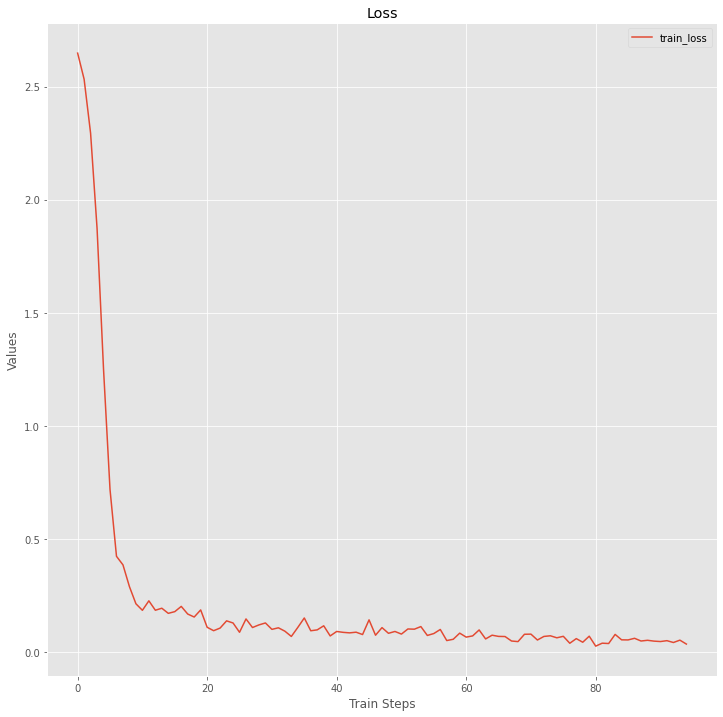

In [63]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    #loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [64]:
eval_history

{'epoch': 5.0,
 'eval_accuracy': 0.962934737425523,
 'eval_loss': 0.09296862035989761,
 'eval_runtime': 12.5859,
 'eval_samples_per_second': 30.272,
 'eval_steps_per_second': 0.477}